In [116]:
from dask.distributed import Client

In [2]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit=8e9, ip="0.0.0.0")
client

/opt/conda/lib/python3.10/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33791 instead
  warnings.warn(
2023-09-04 09:09:03,081 - distributed.diskutils - INFO - Found stale lock file and directory '/work/notebooks/preliminary-experiment/dask-worker-space/worker-ksdiz981', purging
2023-09-04 09:09:03,090 - distributed.diskutils - INFO - Found stale lock file and directory '/work/notebooks/preliminary-experiment/dask-worker-space/worker-nkumukvs', purging
2023-09-04 09:09:03,098 - distributed.diskutils - INFO - Found stale lock file and directory '/work/notebooks/preliminary-experiment/dask-worker-space/worker-21bcj1ea', purging
2023-09-04 09:09:03,105 - distributed.diskutils - INFO - Found stale lock file and directory '/work/notebooks/preliminary-experiment/dask-worker-space/worker-9tgblpiv', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://134.245.3.13:33791/status,
Dashboard: http://134.245.3.13:33791/status,Workers: 4
Total threads: 8,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://134.245.3.13:42991,Workers: 4
Dashboard: http://134.245.3.13:33791/status,Total threads: 8
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://134.245.3.13:46651,Total threads: 2
Dashboard: http://134.245.3.13:41315/status,Memory: 7.45 GiB
Nanny: tcp://134.245.3.13:42021,


In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point

In [4]:
INALT_mask=xr.open_dataset('/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/1_INALT20.L46-KFS119_mesh_mask_iMirabilis.nc')
particle_ds = xr.open_dataset('../../output_data/INALT20.L46-KFS119/Column_test_1500_20090301_RT-42_N-100000_seed-12345.nc')
SIGMA=xr.open_dataset('../../data/config/ROMS/sigma2depth_parent.nc')
ROMS_ds = xr.open_dataset('../../output_data/ROMS/Column_test_1500_20090301_RT-42_N-100000_seed-12345.nc') 
SIGMA_child=xr.open_dataset('../../data/config/ROMS/sigma2depth_child.nc')
ROMSchild_ds = xr.open_dataset('../../output_data/ROMS_child/Column_test_1500_20090301_RT-42_N-100000_seed-12345.nc') 
particle_ds

<xarray.Dataset>
Dimensions:     (traj: 100000, obs: 44)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 ...
    lat         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    trajectory  (traj, obs) float64 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

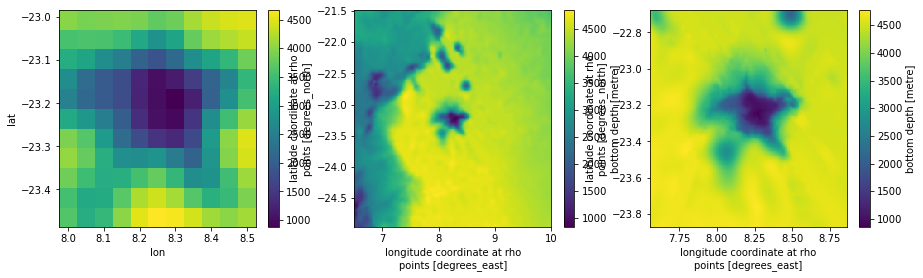

In [5]:
topo_INALT = np.sum((INALT_mask.tmask*INALT_mask.e3t_0).isel(t=0),axis=0)
topo_INALT = topo_INALT.assign_coords({"lon": INALT_mask.glamt.isel(t=0,y=0),
                                       "lat": INALT_mask.gphit.isel(t=0,x=0),
                                      })
topo_INALT = topo_INALT.swap_dims({'x': 'lon', 'y': 'lat'})

plt.figure(figsize=(15,4))
plt.subplot(1, 3,1)
topo_INALT.sel(lon=slice(8,8.5),lat=slice(-23.5,-23)).plot()
plt.subplot(1, 3,2)
SIGMA.h.plot()
plt.subplot(1, 3,3)
SIGMA_child.h.plot();

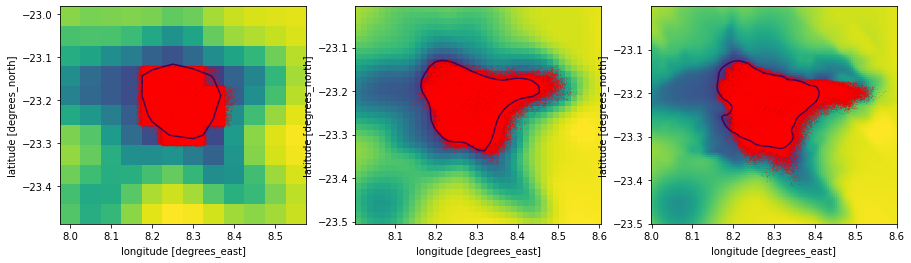

In [14]:
plt.figure(figsize=(15,4))
plt.subplot(1, 3,1)
plt.pcolormesh(topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lon,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lat,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)))#,levels=20)
cl_INALT=plt.contour(topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lon,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lat,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)),levels=[1500])
particle_ds.isel(obs=0).plot.scatter(x='lon',y='lat',s=0.01,color='red')

plt.subplot(1, 3,2)
plt.pcolormesh(SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)))#,levels=20)
cl_ROMS=plt.contour(SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)),levels=[1500])
ROMS_ds.isel(obs=0).plot.scatter(x='lon',y='lat',s=0.01,color='red')

plt.subplot(1, 3,3)
plt.pcolormesh(SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)))#,levels=20)
cl_ROMSchild=plt.contour(SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
            SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)),levels=[1500])
ROMSchild_ds.isel(obs=0).plot.scatter(x='lon',y='lat',s=0.01,color='red');

In [174]:
points_INALT=particle_ds.isel(obs=0).to_pandas().drop(['z','time','trajectory'],axis=1).to_numpy()
points_ROMS=ROMS_ds.isel(obs=0).to_pandas().drop(['z','time','trajectory'],axis=1).to_numpy()
points_ROMSchild=ROMSchild_ds.isel(obs=0).to_pandas().drop(['z','time','trajectory'],axis=1).to_numpy()

In [175]:
hull_INALT=ConvexHull(points_INALT)
hull_ROMS=ConvexHull(points_ROMS)
hull_ROMSchild=ConvexHull(points_ROMSchild)

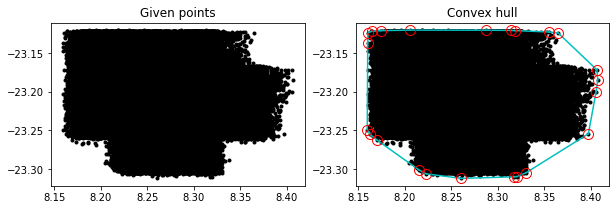

In [176]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))

for ax in (ax1, ax2):
    ax.plot(points_INALT[:, 0], points_INALT[:, 1], '.', color='k')
    if ax == ax1:
        ax.set_title('Given points')
    else:
        ax.set_title('Convex hull')
        for simplex in hull_INALT.simplices:
            ax.plot(points_INALT[simplex, 0], points_INALT[simplex, 1], 'c')
        ax.plot(points_INALT[hull_INALT.vertices, 0], points_INALT[hull_INALT.vertices, 1], 'o', mec='r', color='none', lw=1, markersize=10)
    #ax.set_xticks(range(10))
    #ax.set_yticks(range(10))
plt.show()

In [179]:
#INALT
x = points_INALT[hull_INALT.vertices, 0]
y = points_INALT[hull_INALT.vertices, 1]
poly_INALT = Polygon([(i[0], i[1]) for i in zip(x,y)])
    
#ROMS
x = points_ROMS[hull_ROMS.vertices, 0]
y = points_ROMS[hull_ROMS.vertices, 1]
poly_ROMS = Polygon([(i[0], i[1]) for i in zip(x,y)])
    
#ROMSchild
x = points_ROMSchild[hull_ROMSchild.vertices, 0]
y = points_ROMSchild[hull_ROMSchild.vertices, 1]
poly_ROMSchild = Polygon([(i[0], i[1]) for i in zip(x,y)])

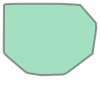

In [178]:
poly_INALT

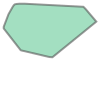

In [180]:
poly_ROMS

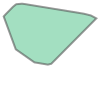

In [181]:
poly_ROMSchild

In [182]:
df_INALT = particle_ds.to_dataframe()
df_ROMS = ROMS_ds.to_dataframe()
df_ROMSchild = ROMSchild_ds.to_dataframe()

df_INALT

lon        lat            z       time  trajectory
traj  obs                                                         
0     0    8.273949 -23.283776  1123.216573 2009-03-01         0.0
      1    8.278039 -23.283673  1121.621875 2009-03-02         0.0
      2    8.281280 -23.283862  1122.544662 2009-03-03         0.0
      3    8.284734 -23.284024  1123.472412 2009-03-04         0.0
      4    8.288584 -23.283856  1124.395437 2009-03-05         0.0
...             ...        ...          ...        ...         ...
99999 39   7.860125 -23.097886   222.388210 2009-04-10     99999.0
      40   7.856773 -23.100825   222.793030 2009-04-11     99999.0
      41   7.856569 -23.105829   222.264411 2009-04-12     99999.0
      42   7.856887 -23.113680   221.838860 2009-04-13     99999.0
      43        NaN        NaN          NaN        NaT         NaN

[4400000 rows x 5 columns]

In [183]:
%%time

df_INALT["is_in_1500"] = df_INALT.apply(lambda row: poly_INALT.contains(
    Point(row.loc["lon"], row.loc["lat"])), axis=1)
df_ROMS["is_in_1500"] = df_ROMS.apply(lambda row: poly_ROMS.contains(
    Point(row.loc["lon"], row.loc["lat"])), axis=1)
df_ROMSchild["is_in_1500"] = df_ROMSchild.apply(lambda row: poly_ROMSchild.contains(
    Point(row.loc["lon"], row.loc["lat"])), axis=1)

CPU times: user 9min 36s, sys: 16.1 s, total: 9min 52s
Wall time: 9min 42s


In [184]:
INALT_1500bool_xr, ROMS_1500bool_xr, ROMSchild_1500bool_xr = df_INALT.to_xarray(), df_ROMS.to_xarray(), df_ROMSchild.to_xarray()

In [185]:
atmount_INALT, atmount_ROMS, atmount_ROMSchild = [], [], []

for i in np.arange(len(INALT_1500bool_xr.obs)):
    cut1 = INALT_1500bool_xr.where(INALT_1500bool_xr.sel(obs=i).is_in_1500 == True, drop = True)
    atmount_INALT.append(len(cut1.traj)/len(particle_ds.traj))
    
for i in np.arange(len(ROMS_1500bool_xr.obs)):
    cut2 = ROMS_1500bool_xr.where(ROMS_1500bool_xr.sel(obs=i).is_in_1500 == True, drop = True)
    atmount_ROMS.append(len(cut2.traj)/len(ROMS_ds.traj))
    
for i in np.arange(len(ROMSchild_1500bool_xr.obs)):
    cut3 = ROMSchild_1500bool_xr.where(ROMSchild_1500bool_xr.sel(obs=i).is_in_1500 == True, drop = True)
    atmount_ROMSchild.append(len(cut3.traj)/len(ROMSchild_ds.traj))

INALT is below the 1/e threshold at obs = 18.0.
ROMS (parent) is below the 1/e threshold at obs = 6.0.
ROMS (child) is below the 1/e threshold at obs = 8.0.


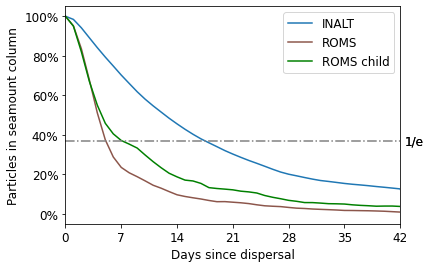

In [198]:
plt.plot(atmount_INALT,label='INALT')
plt.plot(atmount_ROMS, color = 'tab:brown',label='ROMS')
plt.plot(atmount_ROMSchild, color = 'green',label='ROMS child')

threshold = 1/np.e

lines = plt.gca().get_lines()
x_data = lines[0].get_xdata()
y_data1 = lines[0].get_ydata()
y_data2 = lines[1].get_ydata()
y_data3 = lines[2].get_ydata()

intersec_INALT = None
intersec_ROMS = None
intersec_ROMSchild = None

for i in range(len(x_data)):
    if y_data1[i] < threshold and intersec_INALT is None:
        intersec_INALT = x_data[i]
    if y_data2[i] < threshold and intersec_ROMS is None:
        intersec_ROMS = x_data[i]
    if y_data3[i] < threshold and intersec_ROMSchild is None:
        intersec_ROMSchild = x_data[i]

#Intersec times
if intersec_INALT is not None:
    print(f"INALT is below the 1/e threshold at obs = {intersec_INALT}.")
else:
    print(f"INALT does not pass the 1/e threshold.")

if intersec_ROMS is not None:
    print(f"ROMS (parent) is below the 1/e threshold at obs = {intersec_ROMS}.")
else:
    print(f"ROMS (parent) does not pass the 1/e threshold.")

if intersec_ROMSchild is not None:
    print(f"ROMS (child) is below the 1/e threshold at obs = {intersec_ROMSchild}.")
else:
    print(f"ROMS (child) does not pass the 1/e threshold.")

plt.axhline(y=threshold, color='gray', linestyle='-.')
plt.text(42.5,0.35,'1/e',fontsize=12)
plt.text(42.5,0.35,'1/e',fontsize=12)
plt.xticks([0,7,14,21,28,35,42],fontsize=12)
plt.yticks([0,0.2,.4,.6,.8,1],['0%','20%','40%','60%','80%','100%'],fontsize=12)
plt.xlim([0,42])
plt.ylabel('Particles in seamount column',fontsize=12)
plt.xlabel('Days since dispersal',fontsize=12)

plt.legend(fontsize=12)
plt.show()